In [10]:
import warnings 
warnings.filterwarnings('ignore')
import shutil
import os 
from skimage import io
import numpy as np
import matplotlib.pyplot as plt 
import random
from PIL import Image
from torch.autograd import Variable 
from sklearn.metrics import accuracy_score
import pandas as pd
import copy


In [11]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torch.nn as nn
import torchvision

In [12]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [13]:
import zipfile
# Прописываем путь к файлу с архивом
zip_file = '/content/drive/MyDrive/CNN_LSTM/frames.zip'

# Распаковываем архив
z = zipfile.ZipFile(zip_file, 'r')
z.extractall()


### Подгрузка данных без трансформа и экстрактора  

In [14]:
class Make_Dataset(Dataset):

    def __init__(self, root_dir, ):
        
        
        # Дир с сетом
        self.root_dir = root_dir
        
        # Название файлов с драками
        self.fight_names = os.listdir(self.root_dir + 'fight')
        # Название файлов с без драк
        self.nonfight_names = os.listdir(self.root_dir + 'noFight')
        self.all_dirs = [self.root_dir + 'fight/' + i for i in self.fight_names] +\
        [self.root_dir + 'noFight/' + i for i in self.nonfight_names] 
        
        random.shuffle(self.all_dirs) 
        
        self.my_transforms = transforms.Compose([
                                transforms.Resize((720, 1280)),
                                
                                ])

    def __len__(self):
        
        #Размер сета
        return len(os.listdir(self.root_dir + 'fight'))+len(os.listdir(self.root_dir + 'noFight'))

    
    # Обработка последовательног набора фотограф
    def __work_with_one_dir(self,idx,):
        
        images = []
        
            
        # Путь с набором фоток для 1 видео
        dirs = self.all_dirs[idx]
            
        # Полные пути фоток с драками для 1 видео 
        img_names = [os.path.join(dirs + '/'+i) for i in os.listdir(dirs)]
            
        for i in img_names:
            # Грузим
            
            images.append(np.array(self.my_transforms(Image.open(i))))
            #images.append(np.array(Image.open(i)))

            
        
        if 'noFight' in self.all_dirs[idx]:
            
            sample = { 'data':np.array(images),'lbl': 0}
        
        else:
            
            sample = { 'data':np.array(images),'lbl': 1}
        
       
       
        return sample
        
        
    # Получаем 1 набор данных                                                         
    def __getitem__(self, idx):
        
        if torch.is_tensor(idx):
                idx = idx.tolist()
                
        
        sample = self.__work_with_one_dir(idx,)
            
            
       

        

        return sample

In [15]:
dataset = Make_Dataset('frames/test/',)

In [16]:
dataset.__len__()

20

In [17]:
for i in dataset:
    
    
    if i['lbl'] == 0:
        
        break

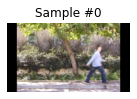

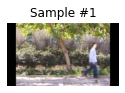

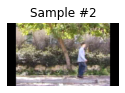

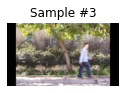

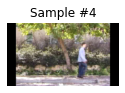

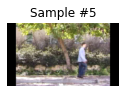

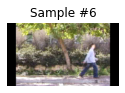

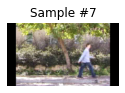

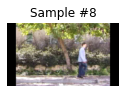

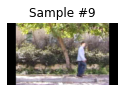

In [18]:
# Без драки
number_of_frames=10
for k in range(len(i['data'])):
    plt.figure(figsize=(20,20))
    ax = plt.subplot(1, number_of_frames, k + 1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(k))
    ax.axis('off')
    plt.imshow(i['data'][k])

In [19]:
ind = 0 
for i in dataset:
    
    
    if i['lbl'] == 1:
        
        break

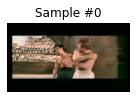

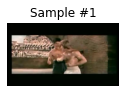

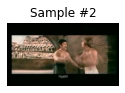

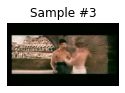

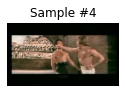

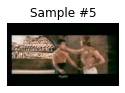

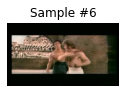

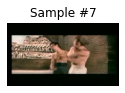

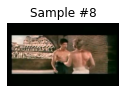

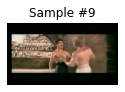

In [20]:
# С дракой 
for k in range(len(i['data'])):
    plt.figure(figsize=(20,20))
    ax = plt.subplot(1, number_of_frames, k + 1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(k))
    ax.axis('off')
    plt.imshow(i['data'][k])

In [21]:
dataloader = DataLoader(dataset, batch_size=1,
                        shuffle=False, num_workers=0,)

In [22]:
for i_batch, sample_batched in enumerate(dataloader):
    print(i_batch, sample_batched['data'].size(),
          sample_batched['lbl'].size())

0 torch.Size([1, 10, 720, 1280, 3]) torch.Size([1])
1 torch.Size([1, 10, 720, 1280, 3]) torch.Size([1])
2 torch.Size([1, 10, 720, 1280, 3]) torch.Size([1])
3 torch.Size([1, 10, 720, 1280, 3]) torch.Size([1])
4 torch.Size([1, 10, 720, 1280, 3]) torch.Size([1])
5 torch.Size([1, 10, 720, 1280, 3]) torch.Size([1])
6 torch.Size([1, 10, 720, 1280, 3]) torch.Size([1])
7 torch.Size([1, 10, 720, 1280, 3]) torch.Size([1])
8 torch.Size([1, 10, 720, 1280, 3]) torch.Size([1])
9 torch.Size([1, 10, 720, 1280, 3]) torch.Size([1])
10 torch.Size([1, 10, 720, 1280, 3]) torch.Size([1])
11 torch.Size([1, 10, 720, 1280, 3]) torch.Size([1])
12 torch.Size([1, 10, 720, 1280, 3]) torch.Size([1])
13 torch.Size([1, 10, 720, 1280, 3]) torch.Size([1])
14 torch.Size([1, 10, 720, 1280, 3]) torch.Size([1])
15 torch.Size([1, 10, 720, 1280, 3]) torch.Size([1])
16 torch.Size([1, 10, 720, 1280, 3]) torch.Size([1])
17 torch.Size([1, 10, 720, 1280, 3]) torch.Size([1])
18 torch.Size([1, 10, 720, 1280, 3]) torch.Size([1])
19 

### BI-LSTM class

In [23]:
class LSTM1(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length):
        super(LSTM1, self).__init__()
        self.num_classes = num_classes #number of classes
        self.num_layers = num_layers #number of layers
        self.input_size = input_size #input size
        self.hidden_size = hidden_size #hidden state
        self.seq_length = seq_length #sequence length

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                          num_layers=num_layers, batch_first=True, bidirectional =True) #lstm
        #self.fc_1 =  nn.Linear(self.hidden_size*2*self.num_layers, 1024)
        self.fc_1 =  nn.Linear(self.hidden_size*2, 1024) #fully connected 1
        self.fc = nn.Linear(1024, num_classes) #fully connected last layer

        self.relu = nn.ReLU()
        self.softmax = nn.Softmax()
    
    def forward(self,x):
        h_0 = Variable(torch.zeros(self.num_layers*2, x.size(0), self.hidden_size)) #hidden state
        c_0 = Variable(torch.zeros(self.num_layers*2, x.size(0), self.hidden_size)) #internal state
        # Propagate input through LSTM
        output, (hn, cn) = self.lstm(x, (h_0, c_0)) #lstm with input, hidden, and internal state
        
        hn = hn.view(-1, self.hidden_size*2*self.num_layers) #reshaping the data for Dense layer next
        #out = self.relu(hn)
        out=self.relu(output[:,-1,:])
        out = self.fc_1(out) #first Dense
        out = self.relu(out) #relu
        out = self.fc(out) #Final Output
        return out

### Для сохран тенз

In [24]:
def save_tensor(dataloader, name):
    



    data = []
    lbls = []
    for i in dataloader:
    
        data = data + list(np.array(i['data']))
        lbls = lbls + list(np.array(i['lbl']))
        
    torch.save(torch.tensor(data), name + '_data.pt')
    torch.save(torch.tensor(lbls), name + '_lbl.pt')



### Класс для extracted_dataset

In [25]:
class Make_extracted_Dataset(Dataset):

    def __init__(self, my_dict, ):
        
        self.my_dict = my_dict
       

    def __len__(self):
        
        #Размер сета
        return len(self.my_dict['lbl'])

        
        
    # Получаем 1 набор данных                                                         
    def __getitem__(self, idx):
        
        if torch.is_tensor(idx):
                idx = idx.tolist()
                
        
        sample = {'data':self.my_dict['data'][idx], 'lbl': self.my_dict['lbl'][idx]}
            
            
       

        

        return sample

### Функции для обучения

In [26]:
def creat_extracted_dataset(extraktor, dataset,size,number_of_frames):
    
    lbls = []
    inputs = []
    for i in dataset:
        
        extracketed_input = [extraktor(i['data'][k].reshape((number_of_frames,3,720,1280)).float())\
                             .detach().numpy() for k in range(len(i['data']))]
        
        extracketed_input = torch.tensor(extracketed_input).reshape((i['data'].shape[0],number_of_frames,size))
        
        
        
        
        
        
        lbls = lbls +list(i['lbl'])
        inputs = inputs + list(np.array(extracketed_input))
    
    return  np.array(inputs),np.array(lbls),
        




def train( model, criterion,  optimizer, train_dataloader, val_dataloader, num_epochs ):
    
    
    # Define your execution device
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print("The model will be running on", device, "device")
    # Convert model parameters and buffers to CPU or Cuda
    model.to(device)
    
    best_metric = 0
    best_accuracy = 0
    loss_train_hist = []
    loss_val_hist = []
    accuracy_train_hist = []
    accuracy_val_hist = []

    for epoch in range(num_epochs):
    
        for i in train_dataloader:
            
            
            
        
            lbl = Variable(torch.nn.functional.one_hot(i['lbl'],num_classes=2).to(device)) 
            data = Variable(i['data'].to(device))
        
        
            outputs = model.forward(data) #forward pass
            optimizer.zero_grad() #caluclate the gradient, manually setting to 0
 
            # obtain the loss functio
        
        
        
            loss = criterion(outputs, lbl.float())


        
        
 
            loss.backward() #calculates the loss of the loss function
 
            optimizer.step() #improve from loss, i.e backprop
    
    
    
    
        preds = []
        lbls = []
        for i in val_dataloader:
            
            
            
        
            lbl = list(np.array(i['lbl']))
            lbls = lbls + lbl
    
            outputs = list(np.array(model.forward(Variable(i['data'].to(device))).argmax(1).cpu())) #forward pass
            preds = preds + outputs
        
        
        
    
     
        loss = float(criterion(torch.nn.functional.one_hot(torch.tensor(lbls),num_classes=2).float(),
                           torch.nn.functional.one_hot(torch.tensor(preds), num_classes=2).float()))
        acc = accuracy_score(lbls, preds)

        loss_val_hist.append(loss)
        accuracy_val_hist.append(acc)
    
        
    
        print(f'Точность на валедации на эпохе {epoch+1} = {acc}')
        print(f'Loss на валедации на эпохе {epoch+1} = {loss}')
    
        if acc > best_accuracy:
        
            best_model_wts = copy.deepcopy(model.state_dict())
            best_accuracy = acc
    
        preds = []
        lbls = []
        for i in train_dataloader_extracted:
        
        
            
            lbl = list(np.array(i['lbl']))
            lbls = lbls + lbl
    
            outputs = list(np.array(model.forward(Variable(i['data'].to(device))).argmax(1).cpu())) #forward pass
            preds = preds + outputs
        
        
        
    
     
        loss = float(criterion(torch.nn.functional.one_hot(torch.tensor(lbls),num_classes=2).float(),
                           torch.nn.functional.one_hot(torch.tensor(preds), num_classes=2).float()))
    
        acc = accuracy_score(lbls, preds)
    
        loss_train_hist.append(loss)
        accuracy_train_hist.append(acc)
        print(f'Точность на трейне на эпохе {epoch+1} = {acc}')
        print(f'Loss на трейне на эпохе {epoch+1} = {loss}')

    return best_model_wts, loss_train_hist, loss_val_hist, accuracy_train_hist , accuracy_val_hist 




### Обучение

In [27]:
train_dataset = Make_Dataset('frames/train/')

test_dataloader = Make_Dataset('frames/test/')

train_dataloader = DataLoader(train_dataset, batch_size=4,
                        shuffle=True, num_workers=0,)


test_dataloader = DataLoader(test_dataloader, batch_size=4,
                        shuffle=True, num_workers=0,)

In [28]:
extraktor = torchvision.models.resnet152(pretrained=True)
extraktor = torch.nn.Sequential(*(list(extraktor.children())[:-1]))




Downloading: "https://download.pytorch.org/models/resnet152-394f9c45.pth" to /root/.cache/torch/hub/checkpoints/resnet152-394f9c45.pth


  0%|          | 0.00/230M [00:00<?, ?B/s]

In [29]:
%%time
data, lbls = creat_extracted_dataset(extraktor, test_dataloader,2048,number_of_frames)
test_dataloader_extracted = DataLoader(Make_extracted_Dataset({'data':data, 'lbl':lbls}), batch_size=4,
                                       shuffle=True, num_workers=0,)

CPU times: user 30min 21s, sys: 40.5 s, total: 31min 1s
Wall time: 7min 49s


In [30]:
%%time
data, lbls = creat_extracted_dataset(extraktor, train_dataloader,2048,number_of_frames)
train_dataloader_extracted = DataLoader(Make_extracted_Dataset({'data':data, 'lbl':lbls}), batch_size=4,
                                        shuffle=True, num_workers=0,)

CPU times: user 4h 34min 2s, sys: 15.8 s, total: 4h 34min 18s
Wall time: 1h 9min 14s


In [31]:
save_tensor(test_dataloader_extracted, 'test')
save_tensor(train_dataloader_extracted, 'train')

In [32]:
import shutil

In [33]:
shutil.copyfile('/content/test_data.pt','/content/drive/MyDrive/CNN_LSTM/test_data.pt')
shutil.copyfile('/content/test_lbl.pt','/content/drive/MyDrive/CNN_LSTM/test_lbl.pt')

'/content/drive/MyDrive/CNN_LSTM/test_lbl.pt'

In [34]:
shutil.copyfile('/content/train_data.pt','/content/drive/MyDrive/CNN_LSTM/train_data.pt')
shutil.copyfile('/content/train_lbl.pt','/content/drive/MyDrive/CNN_LSTM/train_lbl.pt')

'/content/drive/MyDrive/CNN_LSTM/train_lbl.pt'